<html><h1>FEC Time Series</h1></html>
This notebook takes a csv of receipts downloaded from the FEC and generates a plot of the contributions over a specified time frame.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from urllib.request import urlopen

Entry Cells

In [33]:
#ENTRIES
csv_path=r"csvs\cunningham-nc-sen-receipts-2019-2020.csv"
time_type='custom' ## 'quarter' or 'custom'. 
interval='2D' ## if you want to smooth out the data/reduce noise you can add an interval here ('1D','3D','1W', etc.)
side='right' ## which side of the bucket to count from if averaging over an interval

#quarter selections- can ignore if using 'custom'
select_quarter='Q4' ## if interested in looking at specific quarter: Inputs 'Q1','Q2','Q3,'Q4' for Q4 info. set 
select_year=2020

##custom dates - can ignore if using 'quarter'
start_date=2020,9, 7# start date as year,month,day
end_date=2020,10,5  # end date

##event of note. the example used here is the date of cunninghams bbq apron gaffe
event_yes_no='yes' ## want to plot an event or not?
event_description='BBQ Mishap'
event_date=2020,9,28

Data Processing

In [30]:
fundraising_raw=pd.read_csv(csv_path, low_memory=False)
print(fundraising_raw['committee_name'].head(1).iloc[0].title())

fundraising_raw['receipt_date'] = pd.to_datetime(fundraising_raw['contribution_receipt_date']).dt.date
fundraising_raw['receipt_year'] = pd.DatetimeIndex(fundraising_raw['receipt_date']).year
fundraising_raw['receipt_month'] = pd.DatetimeIndex(fundraising_raw['receipt_date']).month
fundraising_raw['receipt_time'] = pd.to_datetime(fundraising_raw['contribution_receipt_date']).dt.time

fundraising_shrink=fundraising_raw[['report_year','report_type','entity_type_desc','contributor_name'
    ,'contributor_first_name','contributor_middle_name','contributor_last_name','contributor_suffix','contributor_street_1'
    ,'contributor_street_2','contributor_city','contributor_state','contributor_zip','contributor_employer'
    ,'contributor_occupation','receipt_date','receipt_year','receipt_month','receipt_time','contribution_receipt_amount','contributor_aggregate_ytd',
    'donor_committee_name','election_type','schedule_type_full']]

Cal For Nc


In [34]:
#conversions
if time_type=='quarter':
    if select_quarter=='Q1':
        start=datetime.date(select_year,1,1)
        end=datetime.date(select_year,3,31)
    elif select_quarter=='Q2':
        start=datetime.date(select_year,4,1)
        end=datetime.date(select_year,6,30)
    elif select_quarter=='Q3':
        start=datetime.date(select_year,7,1)
        end=datetime.date(select_year,9,30)
    elif select_quarter=='Q4':
        start=datetime.date(select_year,10,1)
        end=datetime.date(select_year,12,31)
elif time_type=='custom':
    start=datetime.date(start_date[0],start_date[1],start_date[2])
    end=datetime.date(end_date[0],end_date[1],end_date[2])

event=datetime.date(event_date[0],event_date[1],event_date[2])

start_filter=(fundraising_shrink['receipt_date']>=start)
end_filter=(fundraising_shrink['receipt_date']<=end)
fundraising_between=fundraising_shrink[(start_filter&end_filter)]


raised_between=fundraising_between[['receipt_date','contribution_receipt_amount']].groupby('receipt_date').sum()
raised_between.reset_index(inplace=True)
raised_between['receipt_date'] = pd.to_datetime(raised_between['receipt_date'])

count_between=fundraising_between[['receipt_date','contribution_receipt_amount']].groupby('receipt_date').count()
count_between.reset_index(inplace=True)
count_between.rename(columns={'contribution_receipt_amount':'count'}, inplace=True)
count_between['receipt_date'] = pd.to_datetime(count_between['receipt_date'])

raised_interval = raised_between.groupby(pd.Grouper(key='receipt_date', freq=interval, closed=side, label=side)
                                     )['contribution_receipt_amount'].sum().reset_index().sort_values('receipt_date')
count_interval =count_between.groupby(pd.Grouper(key='receipt_date', freq=interval, closed=side, label=side)
                                     )['count'].sum().reset_index().sort_values('receipt_date')

Figure generation

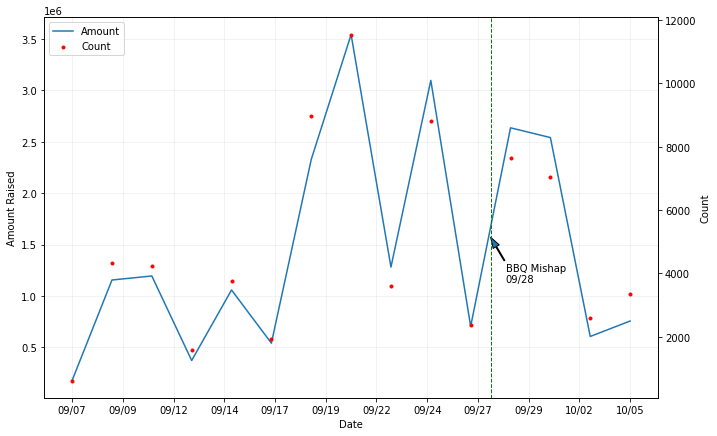

In [36]:
date_ticks=pd.date_range(raised_interval.receipt_date.dt.date.min(),raised_interval.receipt_date.dt.date.max(),periods=12)

fig,ax=plt.subplots(figsize=(11,7)) 
ax2=ax.twinx()                         

ax.grid(visible=True,alpha=0.2)

ax.set_xlabel('Date') 
ax.set_xticks(date_ticks)
ax.set_xticklabels(date_ticks.strftime('%m/%d' if start_date[0]==end_date[0] else '%m/%d/%y'),
                  fontdict={'fontsize':10})

ax.plot(raised_interval['receipt_date'],raised_interval['contribution_receipt_amount'],label='Amount')
ax.set_ylabel('Amount Raised')

# ax.set_yscale('log')

ax2.scatter(count_interval['receipt_date'],count_interval['count'],color='r',marker='.',label='Count')
ax2.set_ylabel('Count')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2,loc='upper left')



###for plotting a vertical line at the time of an event worth investigating
if event_yes_no=='yes':
    plt.axvline(x=event,color='green',lw=1,ls='--')
    xy=(event,raised_between[raised_between['receipt_date']==pd.Timestamp(event)]['contribution_receipt_amount'].item())
    ax.annotate(event_description+'\n' + event.strftime('%m/%d'),
                xy=xy,
                xytext=(15,-45), textcoords='offset points',
                arrowprops={'width':1,
                            'headwidth':7,
                            'headlength':11
                           }
           )

# plt.savefig('time-series.jpg')
plt.show()